In [6]:
#구글 드라이브 연결
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


#### pip

In [ ]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user
# 설치 후 런타임 다시시작

In [ ]:
import sklearn

!pip install pycaret

from pycaret.utils import enable_colab
enable_colab()

!pip install markupsafe==2.0.1
# 설치 후 런타임 다시시작

In [ ]:
import jinja2
from pycaret.regression import *

!pip install catboost

!pip install optuna

import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [ ]:
'''!pip uninstall markupsafe
!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq 
# 설치 후 런타임 다시시작'''

#### h2o automl

In [ ]:
## 0. h2o setup
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip uninstall h2o
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [3]:
#### 1. h2o 분석 준비하기 ####
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
%matplotlib inline
h2o.init()
h2o.no_progress()
# H2O 클러스터 가동 시간, 시간대, 버전, 버전 수명, 클러스터 이름, 할당 된 하드웨어 리소스 (노드 수, 메모리, 코어 수), 연결 URL, 노출 된 H2O API 확장 및 사용 된 파이썬 버전과 같은 추가 정보가 출력

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpgkmdy4gb
  JVM stdout: /tmp/tmpgkmdy4gb/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpgkmdy4gb/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.4
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_unknownUser_7xpedx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.365 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


#### import


In [34]:
# 함수
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import re

# 전처리
import datetime as dt

# 모델
from pycaret.regression import * 
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import ExtraTreesRegressor

# 경고
import warnings
warnings.filterwarnings(action='ignore')

# 성능 평가
from sklearn.metrics import *
from sklearn.model_selection import KFold

def NRMSE(y, pred):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(1,15): # ignore 'ID'
        rmse = metrics.mean_squared_error(y[:,idx], pred[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(y[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:14])
    return score

# 데이터
train = pd.read_csv('./drive/MyDrive/input/자율주행 센서의 안테나 성능 예측 AI 경진대회/train.csv')
test = pd.read_csv('./drive/MyDrive/input/자율주행 센서의 안테나 성능 예측 AI 경진대회/test.csv')
sample_submission = pd.read_csv('./drive/MyDrive/input/자율주행 센서의 안테나 성능 예측 AI 경진대회/sample_submission.csv')

In [35]:
# 시드 고정
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED)

Data Load

In [36]:
X_train = train.filter(regex='X') # Input : X Featrue
y_train = train.filter(regex='Y') # Output : Y Feature
X_test = test.iloc[:, 1:]
X_test.head()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,68.504,103.321,76.67,1,101.867,73.963,30.51,63.57,239.80,0.0,0.0,4.37,0.15,13.38,13.40,13.50,13.53,13.46,3.27,3.32,3.18,3.39,1,2.22,2.14,2.31,2.16,2.32,2.22,1.38,1.53,1.33,1.53,12.96,12.95,12.97,12.88,-16.17,-16.17,-16.84,21.22,21.06,21.21,21.20,0.16,1469,1,1,17227.63,138.130429,129.460682,141.506570,133.427229,129.711498,133.138096,121.859684
1,67.485,103.320,69.37,1,101.992,67.845,28.03,116.99,189.23,0.0,0.0,4.36,0.17,13.35,13.38,13.45,13.52,13.44,3.26,3.30,3.17,3.34,1,2.11,2.10,2.10,2.10,2.17,2.20,1.36,1.56,1.34,1.55,12.94,12.89,13.00,12.88,-15.35,-15.25,-16.01,21.21,20.99,21.26,21.15,0.27,1462,1,1,17134.53,136.148839,128.266277,145.911745,131.196417,132.411480,133.629025,124.178623
2,69.524,103.320,68.97,1,101.884,77.022,29.65,205.68,214.93,0.0,0.0,4.43,0.20,13.32,13.35,13.40,13.52,13.41,3.07,3.12,3.05,3.17,1,2.13,2.10,2.29,2.15,2.24,2.26,1.50,1.69,1.47,1.71,12.93,12.90,13.02,13.01,-16.27,-16.35,-16.95,21.16,21.05,21.15,21.19,0.14,1469,1,1,14860.83,120.447446,119.988804,132.099908,120.450155,130.051708,128.252972,114.475628
3,69.524,103.320,65.87,1,101.866,73.963,28.15,103.38,180.80,0.0,0.0,4.39,0.18,13.32,13.34,13.45,13.50,13.42,3.23,3.11,3.20,3.14,1,2.10,2.10,2.09,2.09,2.10,2.18,1.49,1.65,1.46,1.90,12.99,12.98,12.91,12.96,-16.06,-16.13,-16.75,21.15,21.03,21.16,21.14,0.13,1469,1,1,15252.53,133.994695,125.069180,147.507669,123.142653,125.963665,139.666592,126.589253
4,73.603,103.321,66.67,1,101.891,74.983,29.92,71.20,231.93,0.0,0.0,4.38,0.12,13.38,13.39,13.45,13.50,13.46,3.17,3.20,3.04,3.20,1,2.12,2.11,2.10,2.10,2.12,2.18,1.48,1.73,1.46,1.67,13.01,12.84,12.99,13.01,-16.06,-16.17,-16.76,21.15,21.08,21.12,21.17,0.09,1469,1,1,10752.23,137.918202,135.116192,138.600473,127.173033,137.252712,134.411335,124.020016


In [37]:
# pycaret 데이터 제작
for i in range(1, 15):
  globals()['train{0}'.format(i)] = pd.concat([X_train, y_train.iloc[:, i-1:i]],axis=1)

train1.head()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,Y_01
0,70.544,103.320,67.47,1,101.892,74.983,29.45,62.38,245.71,0.0,0.0,4.34,0.18,13.34,13.37,13.40,13.52,13.44,3.11,3.17,3.06,3.13,1,2.05,2.07,2.05,2.06,2.06,2.35,1.49,1.69,1.46,1.74,12.99,12.88,12.89,12.99,-16.41,-16.36,-17.03,21.20,20.99,21.28,21.09,0.29,1463,1,1,9706.03,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256,2.056
1,69.524,103.321,65.17,1,101.944,72.943,28.73,61.23,233.61,0.0,0.0,4.38,0.18,13.33,13.33,13.46,13.51,13.42,2.97,3.11,2.91,3.20,1,2.10,2.10,2.10,2.10,2.17,2.28,1.49,1.67,1.45,1.66,12.92,12.87,12.89,12.93,-16.06,-16.11,-16.74,21.16,21.03,21.16,21.13,0.13,1463,1,1,10423.43,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308,1.446
2,72.583,103.320,64.07,1,103.153,72.943,28.81,105.77,272.20,0.0,0.0,4.36,0.15,13.36,13.36,13.39,13.51,13.43,3.04,3.04,3.01,3.12,1,2.07,2.06,2.04,2.07,2.10,2.26,1.49,1.69,1.46,1.68,12.97,12.87,12.87,13.00,-16.16,-16.17,-16.76,21.13,21.03,21.17,21.12,0.14,1468,1,1,10948.53,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232,1.251
3,71.563,103.320,67.57,1,101.971,77.022,28.92,115.21,255.36,0.0,0.0,4.33,0.21,13.30,13.33,13.39,13.51,13.40,3.05,3.01,3.02,3.08,1,2.06,2.05,2.03,2.06,2.07,2.12,1.47,1.68,1.47,1.68,12.91,12.97,12.99,12.92,-16.05,-16.03,-16.67,21.18,20.98,21.20,21.09,0.22,1469,1,1,15007.03,134.138760,133.239422,139.720132,132.260824,130.723186,147.624829,134.875225,1.464
4,69.524,103.320,63.57,1,101.981,70.904,29.68,103.38,241.46,0.0,0.0,4.35,0.16,13.35,13.34,13.41,13.50,13.42,3.04,3.07,3.00,3.12,1,2.09,2.06,2.09,2.12,2.33,2.13,1.49,1.68,1.47,1.82,12.96,12.85,12.91,12.96,-16.25,-16.23,-16.85,21.16,20.96,21.18,21.10,0.22,1469,1,1,11051.03,142.728970,136.620022,134.853555,134.760252,125.647793,139.331105,123.272762,0.983


#### h2o automl

##### 1번

In [23]:
# 1시간
train_1 = train1.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_1, test_size=0.2, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_1.columns)
y = "Y_01"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_4_20220808_72758_model_19,0.35083,0.123081,0.270264,0.154567,0.123081
GBM_grid_1_AutoML_4_20220808_72758_model_1,0.351056,0.12324,0.270486,0.15461,0.12324
GBM_5_AutoML_4_20220808_72758,0.351081,0.123258,0.270436,0.154646,0.123258
GBM_grid_1_AutoML_4_20220808_72758_model_21,0.351135,0.123296,0.270339,0.154742,0.123296
GBM_1_AutoML_4_20220808_72758,0.351152,0.123307,0.270653,0.154669,0.123307
GBM_2_AutoML_4_20220808_72758,0.3512,0.123342,0.270736,0.154662,0.123342
GBM_grid_1_AutoML_4_20220808_72758_model_24,0.351313,0.123421,0.270601,0.154767,0.123421
GBM_grid_1_AutoML_4_20220808_72758_model_13,0.351442,0.123511,0.270696,0.154864,0.123511
GBM_grid_1_AutoML_4_20220808_72758_model_18,0.351482,0.12354,0.270384,0.154725,0.12354
GBM_grid_1_AutoML_4_20220808_72758_model_3,0.351603,0.123625,0.270534,0.154962,0.123625


In [24]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.12308142233577374
RMSE: 0.35082962009467467
MAE: 0.27026426063937425
RMSLE: 0.15456657066062582
Mean Residual Deviance: 0.12308142233577374


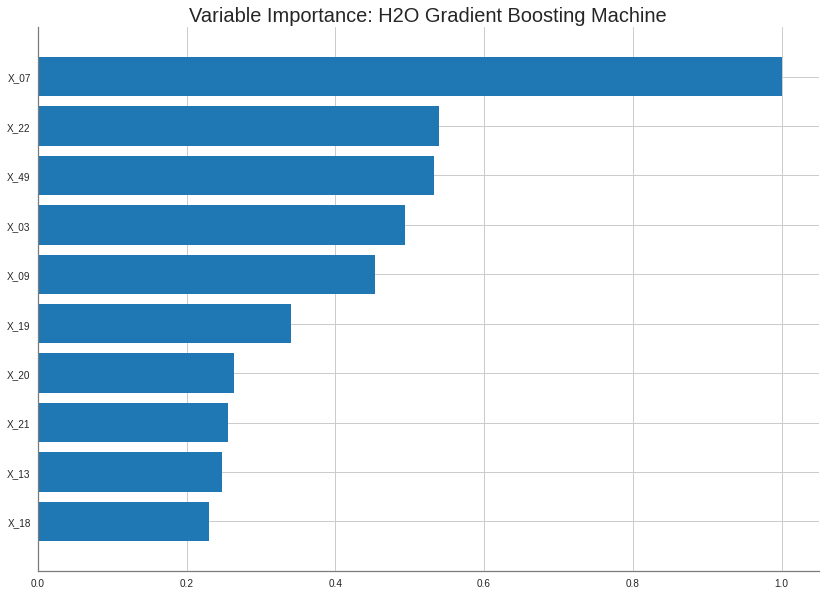

predict
1.37917
1.29191
1.26317
1.40936
1.40462
1.40715
1.2168
1.41567
1.49225
1.30355


Y_01
1.562
0.782
1.038
1.388
1.044
1.226
1.488
1.637
1.895
0.934


<Figure size 432x288 with 0 Axes>

In [26]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)
# [('X_07', 283.6393737792969, 1.0, 0.12518358836648696), ('X_22', 153.10166931152344, 0.5397757979491721, 0.0675710713006612), ('X_49', 151.04347229003906, 0.5325194111011109, 0.06666269075644553), ('X_03', 140.07815551757812, 0.493860050708526, 0.06182317329854851), ('X_09', 128.74620056152344, 0.4539080694124729, 0.056821840917557806), ('X_19', 96.48343658447266, 0.3401623522816954, 0.04258274388580768), ('X_20', 74.9245834350586, 0.2641543818008789, 0.033067793396565064), ('X_21', 72.5791015625, 0.2558851424449084, 0.0320326203409233), ('X_13', 70.29818725585938, 0.2478435427323966, 0.03102594403270416), ('X_18', 65.27365112304688, 0.23012902000635874, 0.02880837651165906), ('X_52', 59.8654670715332, 0.21106190679336087, 0.02642148685986593), ('X_43', 59.586097717285156, 0.21007696118963298, 0.026298187834845478), ('X_05', 58.193382263183594, 0.2051667985576098, 0.02568351605710578), ('X_51', 49.08327102661133, 0.17304815749876673, 0.02166278931590462), ('X_55', 44.14694595336914, 0.15564463200275008, 0.01948415354408561), ('X_06', 42.07295608520508, 0.14833256583743037, 0.018568802863137713), ('X_08', 41.22038650512695, 0.14532674344853483, 0.01819252323050344), ('X_17', 38.10068130493164, 0.134327899534069, 0.016815648481407715), ('X_56', 35.987606048583984, 0.1268780337830895, 0.015883047553851507), ('X_45', 33.45148468017578, 0.11793667513243339, 0.014763736193090642), ('X_14', 33.420860290527344, 0.11782870567374933, 0.014750220188818584), ('X_28', 32.55638885498047, 0.11478092206025309, 0.014368687699516547), ('X_01', 30.54311752319336, 0.10768292538594912, 0.013480135005613786), ('X_31', 30.49063491821289, 0.10749789252439265, 0.013456971928038427), ('X_32', 29.94219398498535, 0.1055643071905938, 0.013214918777540675), ('X_26', 26.549428939819336, 0.09360276250108265, 0.011717529690901573), ('X_29', 25.31772232055664, 0.08926025319833296, 0.011173918793868516), ('X_46', 25.054241180419922, 0.0883313231396249, 0.01105763199577795), ('X_34', 24.32987403869629, 0.08577749173014199, 0.010737934215855834), ('X_53', 23.106868743896484, 0.08146565984832631, 0.010198163628457126), ('X_50', 22.42790985107422, 0.07907191992507231, 0.009898506675248072), ('X_25', 21.57439613342285, 0.07606276888134066, 0.009521810349656983), ('X_27', 21.453689575195312, 0.07563720540396017, 0.009468536786480774), ('X_44', 19.267879486083984, 0.0679309054640508, 0.008503834506974476), ('X_37', 17.860864639282227, 0.06297032884150977, 0.007882851724997881), ('X_54', 17.202125549316406, 0.060647875928190355, 0.007592118735496356), ('X_33', 16.40506362915039, 0.05783775154543728, 0.007240337281507167), ('X_42', 16.021411895751953, 0.05648514760936682, 0.007071013467151232), ('X_40', 15.91661262512207, 0.056115666922558406, 0.007024760548944441), ('X_16', 15.743875503540039, 0.055506664303209656, 0.006948523415729774), ('X_24', 15.417304992675781, 0.05435530613134186, 0.006804392268280285), ('X_39', 14.113567352294922, 0.04975884400054011, 0.006228990644955854), ('X_36', 13.353354454040527, 0.047078634662446155, 0.0058934724224398854), ('X_30', 12.50938892364502, 0.04410314674216818, 0.005520990167438352), ('X_38', 12.240413665771484, 0.04315484660213604, 0.0054022785530606875), ('X_35', 10.450654029846191, 0.03684486356953379, 0.004612372234507889), ('X_41', 8.931245803833008, 0.03148803244355812, 0.003941784891884966), ('X_15', 8.370869636535645, 0.029512368205442157, 0.0036944641531502687), ('X_12', 7.339144229888916, 0.02587491338772871, 0.0032391145065479338), ('X_02', 0.0, 0.0, 0.0), ('X_10', 0.0, 0.0, 0.0), ('X_11', 0.0, 0.0, 0.0)]

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_01'])

In [31]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
preds = aml.predict(h2o_test)
preds

predict
1.39985
1.47602
1.42296
1.42914
1.34291
1.56909
1.38674
1.46019
1.43892
1.43504


In [32]:
# 모델 저장
import pickle

with open('Y_01.pkl', 'wb') as f:
 pickle.dump(preds, f)

##### 2번

In [38]:
# 1시간
train_2 = train2.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_2, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_2.columns)
y = "Y_02"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_5_20220808_84813_model_15,0.378622,0.143355,0.29603,0.186102,0.143355
GBM_5_AutoML_5_20220808_84813,0.378818,0.143503,0.296604,0.186191,0.143503
GBM_grid_1_AutoML_5_20220808_84813_model_13,0.378989,0.143633,0.296531,0.186273,0.143633
GBM_grid_1_AutoML_5_20220808_84813_model_10,0.378997,0.143639,0.296729,0.186297,0.143639
GBM_grid_1_AutoML_5_20220808_84813_model_6,0.379015,0.143652,0.296785,0.186326,0.143652
DeepLearning_grid_1_AutoML_5_20220808_84813_model_15,0.379045,0.143675,0.296811,0.186664,0.143675
GBM_1_AutoML_5_20220808_84813,0.379061,0.143688,0.296234,0.186328,0.143688
GBM_grid_1_AutoML_5_20220808_84813_model_3,0.37909,0.143709,0.297171,0.186289,0.143709
GBM_grid_1_AutoML_5_20220808_84813_model_2,0.379136,0.143744,0.296544,0.186343,0.143744
DeepLearning_grid_1_AutoML_5_20220808_84813_model_14,0.379202,0.143794,0.296585,0.186145,0.143794


In [39]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.14335458039959986
RMSE: 0.3786219491783326
MAE: 0.29602987694757865
RMSLE: 0.18610221976906852
Mean Residual Deviance: 0.14335458039959986


[('X_22', 213.0231170654297, 1.0, 0.0697664574618746), ('X_49', 173.0241241455078, 0.81223167949591, 0.05666652691673837), ('X_07', 149.39830017089844, 0.7013243549760424, 0.0489289157784127), ('X_09', 131.4102325439453, 0.6168824977975648, 0.04303770654156875), ('X_18', 93.77601623535156, 0.44021521010111037, 0.030712255729589306), ('X_21', 92.57965087890625, 0.4345990808615882, 0.030320438287899792), ('X_03', 86.51846313476562, 0.4061458884210751, 0.028335359847844202), ('X_43', 84.9454345703125, 0.3987615792149997, 0.027820182753733214), ('X_20', 84.42792510986328, 0.3963322209952049, 0.027650695036832245), ('X_19', 84.36251831054688, 0.39602518014340704, 0.02762927388430623), ('X_45', 81.20830535888672, 0.3812182756388065, 0.02659624861104398), ('X_06', 69.33683013916016, 0.3254896984624606, 0.022708263202059646), ('X_36', 69.2117919921875, 0.3249027286129196, 0.02266731239502024), ('X_52', 66.06179809570312, 0.31011562972957696, 0.021635668889790984), ('X_05', 62.52201461791992, 0

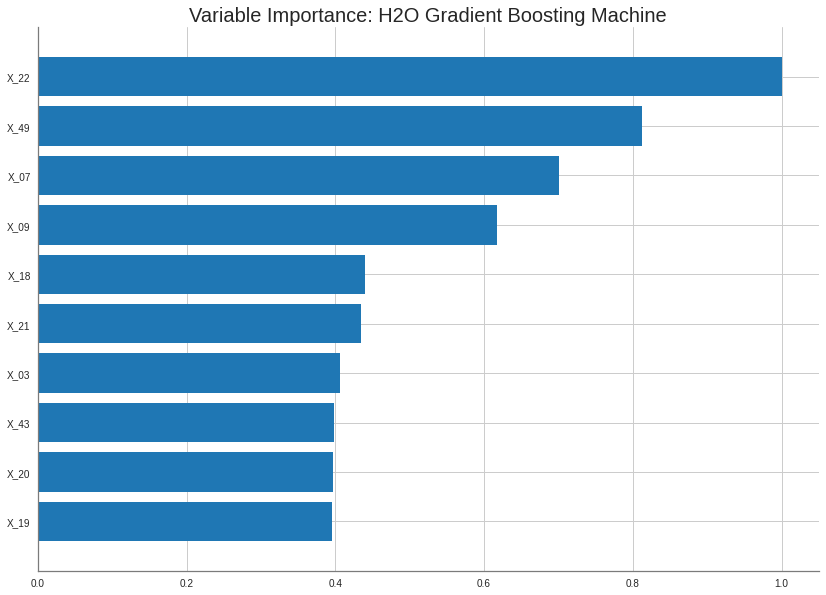

predict
1.00807
1.04047
1.09342
1.06049
1.09763
1.07405
1.09787
1.03418
1.12725
1.07639


Y_02
0.824
0.737
1.146
1.037
1.083
1.154
0.762
0.883
1.007
1.292


<Figure size 432x288 with 0 Axes>

In [41]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_02'])

In [42]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred2 = aml.predict(h2o_test)
pred2

predict
1.21117
1.18629
1.15626
1.14603
1.03103
1.04854
1.05116
1.09153
1.06963
1.0654


In [43]:
# 모델 저장
import pickle

with open('Y_02.pkl', 'wb') as f:
 pickle.dump(pred2, f)

##### 3번

In [46]:
# 1시간
train_3 = train3.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_3, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_3.columns)
y = "Y_03"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_6_20220808_95143_model_17,0.355603,0.126453,0.278793,0.178381,0.126453
GBM_1_AutoML_6_20220808_95143,0.355995,0.126733,0.278953,0.178594,0.126733
GBM_5_AutoML_6_20220808_95143,0.356035,0.126761,0.279441,0.178661,0.126761
GBM_2_AutoML_6_20220808_95143,0.356041,0.126765,0.279449,0.178596,0.126765
GBM_grid_1_AutoML_6_20220808_95143_model_20,0.356048,0.12677,0.279068,0.178648,0.12677
GBM_grid_1_AutoML_6_20220808_95143_model_6,0.356131,0.126829,0.279361,0.178716,0.126829
GBM_grid_1_AutoML_6_20220808_95143_model_15,0.356147,0.126841,0.279446,0.17869,0.126841
GBM_grid_1_AutoML_6_20220808_95143_model_10,0.356229,0.126899,0.279233,0.17877,0.126899
GBM_grid_1_AutoML_6_20220808_95143_model_12,0.356232,0.126901,0.279448,0.178822,0.126901
GBM_grid_1_AutoML_6_20220808_95143_model_22,0.356457,0.127062,0.279608,0.178901,0.127062


In [47]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.1264533279824033
RMSE: 0.35560276711859723
MAE: 0.27879286662903807
RMSLE: 0.1783813628238073
Mean Residual Deviance: 0.1264533279824033


[('X_22', 125.70407104492188, 1.0, 0.05028466159334442), ('X_49', 125.18003845214844, 0.9958312201950391, 0.05007503591159479), ('X_19', 109.62777709960938, 0.872109997618395, 0.0438537561024134), ('X_09', 105.76338958740234, 0.8413680536217997, 0.042307907851823055), ('X_03', 95.41038513183594, 0.7590079170764475, 0.03816645625685838), ('X_43', 90.7936782836914, 0.7222811284389126, 0.03631966211880965), ('X_13', 85.91536712646484, 0.6834732273369408, 0.03436821994474902), ('X_05', 80.35636901855469, 0.6392503309605491, 0.03214448656578463), ('X_07', 76.10697174072266, 0.605445560418842, 0.030444625118854228), ('X_20', 69.64427947998047, 0.5540336036936484, 0.0278593922730762), ('X_51', 65.2489013671875, 0.5190675276051323, 0.026101134969718037), ('X_42', 55.91777420043945, 0.44483662092738874, 0.022368458947660572), ('X_56', 53.86663818359375, 0.42851944042722256, 0.021547955048052198), ('X_52', 52.40073013305664, 0.41685786066809727, 0.020961556456220786), ('X_35', 52.02464294433594,

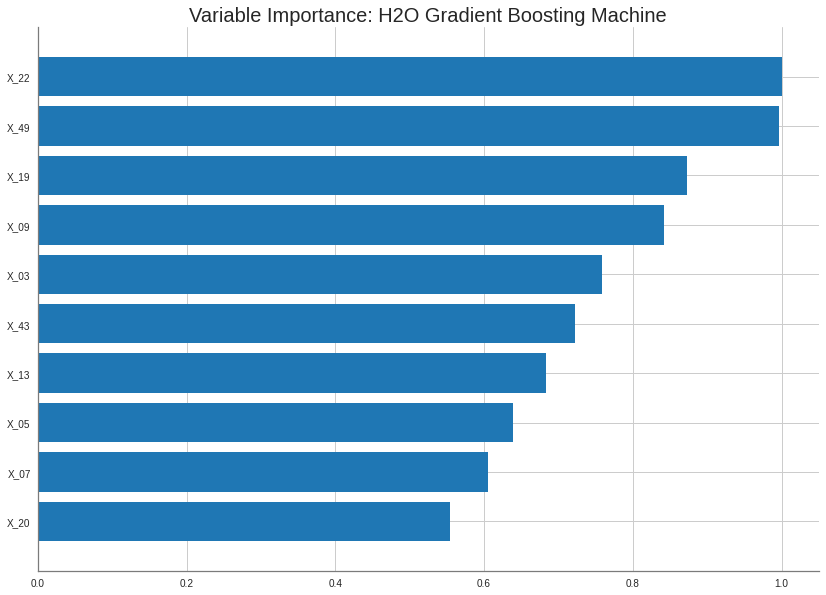

predict
1.05502
1.00726
0.976015
0.976171
1.06318
1.04619
0.876501
1.01939
1.14319
0.999783


Y_03
1.674
0.51
0.758
0.954
0.495
0.87
1.367
1.3
1.502
0.443


<Figure size 432x288 with 0 Axes>

In [48]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_03'])

In [49]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred3 = aml.predict(h2o_test)
pred3

predict
1.08556
1.12616
1.07989
1.05792
0.944714
0.935535
1.06661
0.966312
1.02192
1.02532


In [50]:
# 모델 저장
import pickle

with open('Y_03.pkl', 'wb') as f:
 pickle.dump(pred3, f)

##### 4

In [51]:
# 1시간
train_4 = train4.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_4, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_4.columns)
y = "Y_04"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_7_20220808_105327_model_4,2.56129,6.5602,2.08147,0.190705,6.5602
GBM_1_AutoML_7_20220808_105327,2.56519,6.5802,2.08317,0.1909,6.5802
GBM_grid_1_AutoML_7_20220808_105327_model_3,2.5662,6.5854,2.08547,0.191118,6.5854
GBM_grid_1_AutoML_7_20220808_105327_model_6,2.56727,6.59086,2.08744,0.191181,6.59086
GBM_grid_1_AutoML_7_20220808_105327_model_10,2.5674,6.59153,2.08737,0.19114,6.59153
GBM_grid_1_AutoML_7_20220808_105327_model_7,2.56888,6.59912,2.08848,0.191173,6.59912
GBM_grid_1_AutoML_7_20220808_105327_model_15,2.56901,6.59982,2.08819,0.191244,6.59982
GBM_grid_1_AutoML_7_20220808_105327_model_2,2.56962,6.60295,2.09114,0.19139,6.60295
GBM_grid_1_AutoML_7_20220808_105327_model_18,2.56997,6.60477,2.08861,0.191326,6.60477
GBM_2_AutoML_7_20220808_105327,2.57089,6.6095,2.09286,0.191335,6.6095


In [52]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 6.560204811743738
RMSE: 2.561289677436689
MAE: 2.0814688899293494
RMSLE: 0.19070526120686726
Mean Residual Deviance: 6.560204811743738


[('X_03', 11160.4375, 1.0, 0.05139541075293979), ('X_32', 10483.2626953125, 0.9393236327260917, 0.04827692393390103), ('X_09', 8308.2470703125, 0.7444373995475088, 0.03826066592959457), ('X_07', 8221.4267578125, 0.7366581066210443, 0.03786084597427148), ('X_21', 7952.8125, 0.7125896722238712, 0.03662383890224859), ('X_49', 7474.16162109375, 0.6697014898469482, 0.03441958315253964), ('X_19', 6982.76904296875, 0.6256716229062481, 0.03215665005572507), ('X_20', 6692.2646484375, 0.5996417836162337, 0.030818835773581767), ('X_30', 6506.95849609375, 0.5830379405909266, 0.02996547444121878), ('X_51', 6435.1318359375, 0.5766021122323833, 0.02963470239919603), ('X_05', 6419.78759765625, 0.5752272343854128, 0.029564039987515858), ('X_52', 5135.904296875, 0.4601884376732543, 0.023651573777970534), ('X_37', 5017.7568359375, 0.44960216263363334, 0.02310748782396562), ('X_15', 4847.564453125, 0.43435254694316416, 0.022323727561729484), ('X_54', 4733.1240234375, 0.4240984301410675, 0.0217967130167771

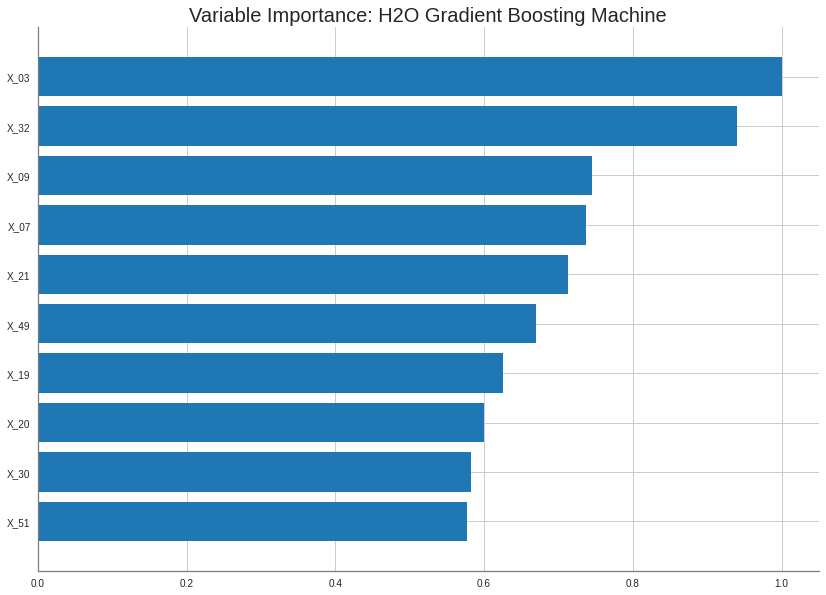

predict
13.0756
13.4349
13.9797
13.7379
13.1571
14.2164
14.6834
13.8719
12.8431
14.5975


Y_04
12.955
11.211
13.277
13.97
16.124
10.648
16.442
12.673
16.436
17.092


<Figure size 432x288 with 0 Axes>

In [53]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_04'])

In [54]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred4 = aml.predict(h2o_test)
pred4

predict
13.8984
13.6166
15.3276
15.0367
15.0515
15.0551
15.4285
14.5751
15.0372
15.0378


In [55]:
# 모델 저장
import pickle

with open('Y_04.pkl', 'wb') as f:
 pickle.dump(pred4, f)

##### 5 

In [ ]:
# 1시간
train_5 = train5.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_5, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_5.columns)
y = "Y_05"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_05'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred5 = aml.predict(h2o_test)
pred5

In [ ]:
# 모델 저장
import pickle

with open('Y_05.pkl', 'wb') as f:
 pickle.dump(pred5, f)

##### 6

In [ ]:
# 1시간
train_6 = train6.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_6, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_6.columns)
y = "Y_06"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_06'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred6 = aml.predict(h2o_test)
pred6

In [ ]:
# 모델 저장
import pickle

with open('Y_06.pkl', 'wb') as f:
 pickle.dump(pred6, f)

##### 7

In [ ]:
# 1시간
train_5 = train5.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_5, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_5.columns)
y = "Y_05"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_07'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred7 = aml.predict(h2o_test)
pred7

In [ ]:
# 모델 저장
import pickle

with open('Y_07.pkl', 'wb') as f:
 pickle.dump(pred7, f)

##### 8

In [ ]:
# 1시간
train_5 = train5.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_5, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_5.columns)
y = "Y_05"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_08'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred8 = aml.predict(h2o_test)
pred8

In [ ]:
# 모델 저장
import pickle

with open('Y_08.pkl', 'wb') as f:
 pickle.dump(pred8, f)

##### 9

In [ ]:
# 1시간
train_5 = train5.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_5, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_5.columns)
y = "Y_05"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_09'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred9 = aml.predict(h2o_test)
pred9

In [ ]:
# 모델 저장
import pickle

with open('Y_09.pkl', 'wb') as f:
 pickle.dump(pred9, f)

##### 10

In [ ]:
# 1시간
train_5 = train5.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_5, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_5.columns)
y = "Y_05"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_10'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred10 = aml.predict(h2o_test)
pred10

In [ ]:
# 모델 저장
import pickle

with open('Y_10.pkl', 'wb') as f:
 pickle.dump(pred10, f)

##### 11

In [ ]:
# 1시간
train_5 = train5.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_5, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_5.columns)
y = "Y_05"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_11'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred11 = aml.predict(h2o_test)
pred11

In [ ]:
# 모델 저장
import pickle

with open('Y_11.pkl', 'wb') as f:
 pickle.dump(pred11, f)

##### 12

In [ ]:
# 1시간
train_5 = train5.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_5, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_5.columns)
y = "Y_05"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_12'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred12 = aml.predict(h2o_test)
pred12

In [ ]:
# 모델 저장
import pickle

with open('Y_12.pkl', 'wb') as f:
 pickle.dump(pred12, f)

##### 13

In [ ]:
# 1시간
train_5 = train5.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_5, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_5.columns)
y = "Y_05"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_13'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred13 = aml.predict(h2o_test)
pred13

In [ ]:
# 모델 저장
import pickle

with open('Y_13.pkl', 'wb') as f:
 pickle.dump(pred13, f)

##### 14

In [ ]:
# 1시간
train_5 = train5.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_5, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_5.columns)
y = "Y_05"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_14'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred14 = aml.predict(h2o_test)
pred14

In [ ]:
# 모델 저장
import pickle

with open('Y_14.pkl', 'wb') as f:
 pickle.dump(pred14, f)

#### pycaret1


In [ ]:
# 모델링
model = setup(train, target = 'Y_01', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
top5 = compare_models(exclude = ['svm'],round=4,n_select=5,sort='RMSE')
tuned_top5 = [tune_model(i) for i in top5] # 모델 안의 파라미터 값 튜닝
blender_top5 = stack_models(estimator_list=tuned_top5) # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)

### pycaret

In [ ]:
# pycaret 데이터 제작
for i in range(1, 15):
  globals()['train{0}'.format(i)] = pd.concat([X_train, y_train.iloc[:, i-1:i]],axis=1)

train1.head()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,Y_01
0,70.544,103.320,67.47,1,101.892,74.983,29.45,62.38,245.71,0.0,0.0,4.34,0.18,13.34,13.37,13.40,13.52,13.44,3.11,3.17,3.06,3.13,1,2.05,2.07,2.05,2.06,2.06,2.35,1.49,1.69,1.46,1.74,12.99,12.88,12.89,12.99,-16.41,-16.36,-17.03,21.20,20.99,21.28,21.09,0.29,1463,1,1,9706.03,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256,2.056
1,69.524,103.321,65.17,1,101.944,72.943,28.73,61.23,233.61,0.0,0.0,4.38,0.18,13.33,13.33,13.46,13.51,13.42,2.97,3.11,2.91,3.20,1,2.10,2.10,2.10,2.10,2.17,2.28,1.49,1.67,1.45,1.66,12.92,12.87,12.89,12.93,-16.06,-16.11,-16.74,21.16,21.03,21.16,21.13,0.13,1463,1,1,10423.43,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308,1.446
2,72.583,103.320,64.07,1,103.153,72.943,28.81,105.77,272.20,0.0,0.0,4.36,0.15,13.36,13.36,13.39,13.51,13.43,3.04,3.04,3.01,3.12,1,2.07,2.06,2.04,2.07,2.10,2.26,1.49,1.69,1.46,1.68,12.97,12.87,12.87,13.00,-16.16,-16.17,-16.76,21.13,21.03,21.17,21.12,0.14,1468,1,1,10948.53,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232,1.251
3,71.563,103.320,67.57,1,101.971,77.022,28.92,115.21,255.36,0.0,0.0,4.33,0.21,13.30,13.33,13.39,13.51,13.40,3.05,3.01,3.02,3.08,1,2.06,2.05,2.03,2.06,2.07,2.12,1.47,1.68,1.47,1.68,12.91,12.97,12.99,12.92,-16.05,-16.03,-16.67,21.18,20.98,21.20,21.09,0.22,1469,1,1,15007.03,134.138760,133.239422,139.720132,132.260824,130.723186,147.624829,134.875225,1.464
4,69.524,103.320,63.57,1,101.981,70.904,29.68,103.38,241.46,0.0,0.0,4.35,0.16,13.35,13.34,13.41,13.50,13.42,3.04,3.07,3.00,3.12,1,2.09,2.06,2.09,2.12,2.33,2.13,1.49,1.68,1.47,1.82,12.96,12.85,12.91,12.96,-16.25,-16.23,-16.85,21.16,20.96,21.18,21.10,0.22,1469,1,1,11051.03,142.728970,136.620022,134.853555,134.760252,125.647793,139.331105,123.272762,0.983


#### top5 1~15

In [ ]:
# 모델링 11분
model = setup(train2, target = 'Y_02', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
top5 = compare_models(exclude = ['svm'],round=4,n_select=5,sort='RMSE')
top5

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2963,0.1426,0.3776,0.0390,0.1871,0.5509,8.647
lightgbm,Light Gradient Boosting Machine,0.2967,0.1427,0.3778,0.0382,0.1871,0.5467,0.487
et,Extra Trees Regressor,0.2968,0.1432,0.3783,0.0353,0.1876,0.5532,12.611
rf,Random Forest Regressor,0.2972,0.1432,0.3783,0.0353,0.1875,0.5476,30.977
lr,Linear Regression,0.2976,0.1438,0.3792,0.0310,0.1879,0.5554,0.293
ridge,Ridge Regression,0.2976,0.1438,0.3792,0.0310,0.1879,0.5554,0.026
br,Bayesian Ridge,0.2977,0.1438,0.3792,0.0307,0.1880,0.5567,0.045
huber,Huber Regressor,0.2972,0.1440,0.3795,0.0296,0.1874,0.5485,0.312
omp,Orthogonal Matching Pursuit,0.2994,0.1450,0.3808,0.0226,0.1888,0.5607,0.026
lar,Least Angle Regression,0.3006,0.1468,0.3831,0.0106,0.1900,0.5570,0.029


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=530, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split

[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=530, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False),
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               ran

In [ ]:
# 모델링 11분
model = setup(train3, target = 'Y_03', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2784,0.1264,0.3555,0.0337,0.1786,0.4038,7.220
lightgbm,Light Gradient Boosting Machine,0.2787,0.1268,0.3560,0.0306,0.1788,0.4019,0.404
et,Extra Trees Regressor,0.2790,0.1268,0.3560,0.0306,0.1790,0.4047,12.176
rf,Random Forest Regressor,0.2795,0.1270,0.3563,0.0291,0.1791,0.4033,30.693
lr,Linear Regression,0.2798,0.1275,0.3571,0.0248,0.1795,0.4071,0.033
ridge,Ridge Regression,0.2798,0.1275,0.3571,0.0248,0.1795,0.4071,0.025
br,Bayesian Ridge,0.2797,0.1276,0.3571,0.0247,0.1796,0.4076,0.057
huber,Huber Regressor,0.2794,0.1278,0.3574,0.0232,0.1791,0.4008,0.411
omp,Orthogonal Matching Pursuit,0.2821,0.1293,0.3596,0.0110,0.1809,0.4120,0.028
lar,Least Angle Regression,0.2822,0.1295,0.3598,0.0096,0.1810,0.4090,0.030


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=530, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=530, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train4, target = 'Y_04', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,2.0938,6.9241,2.6274,0.0606,0.1924,0.1735,32.461
et,Extra Trees Regressor,2.0958,6.9282,2.6282,0.0599,0.1925,0.1737,13.315
lightgbm,Light Gradient Boosting Machine,2.0965,6.9423,2.6309,0.0580,0.1929,0.1741,0.418
gbr,Gradient Boosting Regressor,2.1128,7.0342,2.6484,0.0453,0.1940,0.1757,7.408
lr,Linear Regression,2.1256,7.1015,2.6613,0.0360,0.1951,0.1768,0.032
ridge,Ridge Regression,2.1256,7.1014,2.6613,0.0360,0.1951,0.1768,0.025
br,Bayesian Ridge,2.1264,7.1015,2.6613,0.0359,0.1952,0.1768,0.056
huber,Huber Regressor,2.1202,7.1247,2.6658,0.0326,0.1963,0.1781,0.382
omp,Orthogonal Matching Pursuit,2.1471,7.2225,2.6841,0.0192,0.1968,0.1787,0.027
en,Elastic Net,2.1726,7.3652,2.7106,-0.0003,0.1987,0.1809,0.025


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train5, target = 'Y_05', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2.0013,6.3115,2.5121,0.0301,0.0811,0.0665,7.457
lightgbm,Light Gradient Boosting Machine,1.9976,6.3125,2.5123,0.0299,0.0811,0.0663,0.407
rf,Random Forest Regressor,2.0080,6.3267,2.5151,0.0277,0.0811,0.0665,35.316
et,Extra Trees Regressor,2.0095,6.3419,2.5182,0.0253,0.0812,0.0666,13.876
lr,Linear Regression,2.0076,6.3475,2.5193,0.0245,0.0813,0.0667,0.033
ridge,Ridge Regression,2.0076,6.3475,2.5193,0.0245,0.0813,0.0667,0.027
br,Bayesian Ridge,2.0080,6.3488,2.5195,0.0243,0.0813,0.0667,0.062
huber,Huber Regressor,1.9859,6.4235,2.5342,0.0129,0.0821,0.0665,0.417
omp,Orthogonal Matching Pursuit,2.0245,6.4494,2.5394,0.0089,0.0820,0.0672,0.028
lar,Least Angle Regression,2.0213,6.4596,2.5415,0.0072,0.0820,0.0671,0.031


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=530, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=530, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train6, target = 'Y_06', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7593,3.1476,1.7636,0.1572,0.0844,0.0459,0.404
rf,Random Forest Regressor,0.7535,3.5008,1.8559,0.0786,0.0699,0.0454,38.685
et,Extra Trees Regressor,0.7499,3.5250,1.8631,0.0702,0.0552,0.0451,13.719
gbr,Gradient Boosting Regressor,0.7513,3.6239,1.8867,0.0508,0.0591,0.0453,7.392
lr,Linear Regression,0.7368,3.7849,1.9282,0.0091,0.0475,0.0444,0.034
ridge,Ridge Regression,0.7368,3.7849,1.9282,0.0091,0.0475,0.0444,0.027
br,Bayesian Ridge,0.7317,3.7854,1.9282,0.0093,0.0471,0.0441,0.062
omp,Orthogonal Matching Pursuit,0.7317,3.8007,1.9319,0.0056,0.0470,0.0440,0.028
lar,Least Angle Regression,0.7444,3.8020,1.9328,0.0040,0.0481,0.0448,0.032
en,Elastic Net,0.7192,3.8264,1.9381,-0.0004,0.0459,0.0433,0.027


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# 모델링 11분
model = setup(train7, target = 'Y_07', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.3260,0.1685,0.4105,0.0431,0.1005,0.1072,0.393
rf,Random Forest Regressor,0.3260,0.1690,0.4111,0.0402,0.1007,0.1073,33.099
gbr,Gradient Boosting Regressor,0.3267,0.1697,0.4119,0.0363,0.1010,0.1076,7.269
et,Extra Trees Regressor,0.3273,0.1701,0.4124,0.0338,0.1011,0.1078,13.727
lr,Linear Regression,0.3279,0.1712,0.4137,0.0279,0.1015,0.1081,0.032
ridge,Ridge Regression,0.3279,0.1712,0.4137,0.0279,0.1015,0.1081,0.027
br,Bayesian Ridge,0.3279,0.1712,0.4137,0.0279,0.1015,0.1081,0.061
huber,Huber Regressor,0.3273,0.1715,0.4141,0.0260,0.1014,0.1074,0.411
lar,Least Angle Regression,0.3284,0.1717,0.4143,0.0251,0.1016,0.1082,0.031
omp,Orthogonal Matching Pursuit,0.3296,0.1725,0.4153,0.0202,0.1019,0.1086,0.028


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# 모델링 11분
model = setup(train8, target = 'Y_08', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.4891,0.3966,0.6297,0.0864,0.0229,0.0185,32.115
lightgbm,Light Gradient Boosting Machine,0.4897,0.3984,0.6311,0.0822,0.0230,0.0186,0.396
et,Extra Trees Regressor,0.4907,0.3988,0.6315,0.0813,0.0230,0.0186,12.609
gbr,Gradient Boosting Regressor,0.4910,0.4009,0.6332,0.0763,0.0231,0.0186,7.212
br,Bayesian Ridge,0.4968,0.4103,0.6405,0.0546,0.0233,0.0188,0.057
lr,Linear Regression,0.4968,0.4104,0.6406,0.0545,0.0233,0.0188,0.031
ridge,Ridge Regression,0.4968,0.4104,0.6406,0.0545,0.0233,0.0188,0.028
huber,Huber Regressor,0.4948,0.4121,0.6419,0.0505,0.0234,0.0187,0.494
lar,Least Angle Regression,0.4989,0.4138,0.6432,0.0467,0.0234,0.0189,0.030
omp,Orthogonal Matching Pursuit,0.4999,0.4155,0.6445,0.0428,0.0235,0.0189,0.026


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train9, target = 'Y_09', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.4865,0.3908,0.6251,0.0800,0.0228,0.0184,33.414
lightgbm,Light Gradient Boosting Machine,0.4869,0.3924,0.6264,0.0760,0.0228,0.0184,0.402
et,Extra Trees Regressor,0.4876,0.3927,0.6266,0.0754,0.0228,0.0185,12.661
gbr,Gradient Boosting Regressor,0.4883,0.3952,0.6286,0.0696,0.0229,0.0185,7.231
lr,Linear Regression,0.4938,0.4041,0.6356,0.0486,0.0231,0.0187,0.031
ridge,Ridge Regression,0.4938,0.4041,0.6356,0.0486,0.0231,0.0187,0.025
br,Bayesian Ridge,0.4937,0.4040,0.6356,0.0487,0.0231,0.0187,0.055
lar,Least Angle Regression,0.4948,0.4057,0.6369,0.0447,0.0232,0.0187,0.030
huber,Huber Regressor,0.4918,0.4058,0.6370,0.0446,0.0232,0.0186,0.489
omp,Orthogonal Matching Pursuit,0.4966,0.4087,0.6393,0.0377,0.0233,0.0188,0.026


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train10, target = 'Y_10', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6338,0.7457,0.8632,0.1359,0.0358,0.0280,0.407
rf,Random Forest Regressor,0.6386,0.7565,0.8695,0.1233,0.0360,0.0282,32.313
et,Extra Trees Regressor,0.6408,0.7705,0.8775,0.1074,0.0363,0.0283,12.493
gbr,Gradient Boosting Regressor,0.6393,0.7743,0.8796,0.1029,0.0364,0.0282,7.248
lr,Linear Regression,0.6533,0.8081,0.8986,0.0638,0.0372,0.0288,0.022
ridge,Ridge Regression,0.6533,0.8081,0.8986,0.0638,0.0372,0.0288,0.026
br,Bayesian Ridge,0.6531,0.8081,0.8986,0.0637,0.0372,0.0288,0.055
lar,Least Angle Regression,0.6539,0.8091,0.8992,0.0625,0.0372,0.0288,0.030
huber,Huber Regressor,0.6465,0.8171,0.9036,0.0533,0.0373,0.0284,0.419
omp,Orthogonal Matching Pursuit,0.6623,0.8269,0.9090,0.0420,0.0376,0.0292,0.027


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# 모델링 11분
model = setup(train11, target = 'Y_11', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6378,0.6627,0.8140,0.0369,0.0326,0.0265,0.394
rf,Random Forest Regressor,0.6426,0.6668,0.8166,0.0309,0.0327,0.0267,33.110
gbr,Gradient Boosting Regressor,0.6407,0.6678,0.8172,0.0294,0.0327,0.0266,7.240
et,Extra Trees Regressor,0.6421,0.6679,0.8172,0.0293,0.0327,0.0267,13.123
lr,Linear Regression,0.6457,0.6781,0.8234,0.0146,0.0330,0.0268,0.032
ridge,Ridge Regression,0.6457,0.6781,0.8234,0.0146,0.0330,0.0268,0.017
br,Bayesian Ridge,0.6458,0.6782,0.8235,0.0143,0.0330,0.0268,0.056
omp,Orthogonal Matching Pursuit,0.6477,0.6827,0.8262,0.0078,0.0331,0.0269,0.027
huber,Huber Regressor,0.6412,0.6836,0.8268,0.0065,0.0331,0.0267,0.423
lar,Least Angle Regression,0.6492,0.6856,0.8280,0.0036,0.0331,0.0270,0.030


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# 모델링 11분
model = setup(train12, target = 'Y_12', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.4882,0.3934,0.6271,0.0821,0.0229,0.0186,32.361
et,Extra Trees Regressor,0.4890,0.3943,0.6279,0.0799,0.0229,0.0186,12.615
lightgbm,Light Gradient Boosting Machine,0.4882,0.3945,0.6280,0.0795,0.0229,0.0185,0.407
gbr,Gradient Boosting Regressor,0.4899,0.3977,0.6306,0.0719,0.0230,0.0186,7.219
lr,Linear Regression,0.4953,0.4069,0.6379,0.0503,0.0233,0.0188,0.021
ridge,Ridge Regression,0.4953,0.4069,0.6379,0.0503,0.0233,0.0188,0.025
br,Bayesian Ridge,0.4953,0.4069,0.6379,0.0504,0.0233,0.0188,0.048
huber,Huber Regressor,0.4934,0.4087,0.6393,0.0461,0.0233,0.0187,0.491
lar,Least Angle Regression,0.4968,0.4093,0.6397,0.0449,0.0234,0.0189,0.030
omp,Orthogonal Matching Pursuit,0.4985,0.4120,0.6419,0.0385,0.0234,0.0189,0.026


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train13, target = 'Y_13', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.4864,0.3909,0.6252,0.0833,0.0228,0.0185,32.161
et,Extra Trees Regressor,0.4870,0.3915,0.6257,0.0818,0.0228,0.0185,12.517
lightgbm,Light Gradient Boosting Machine,0.4870,0.3925,0.6265,0.0794,0.0229,0.0185,0.402
gbr,Gradient Boosting Regressor,0.4883,0.3952,0.6286,0.0732,0.0230,0.0186,7.206
br,Bayesian Ridge,0.4939,0.4045,0.6359,0.0514,0.0232,0.0188,0.056
lr,Linear Regression,0.4939,0.4045,0.6360,0.0513,0.0232,0.0188,0.032
ridge,Ridge Regression,0.4939,0.4045,0.6360,0.0513,0.0232,0.0188,0.015
lar,Least Angle Regression,0.4943,0.4049,0.6363,0.0503,0.0232,0.0188,0.031
huber,Huber Regressor,0.4921,0.4062,0.6373,0.0473,0.0233,0.0187,0.488
omp,Orthogonal Matching Pursuit,0.4972,0.4096,0.6400,0.0393,0.0234,0.0189,0.026


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train14, target = 'Y_14', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.4878,0.3930,0.6268,0.0809,0.0229,0.0185,32.223
et,Extra Trees Regressor,0.4887,0.3937,0.6274,0.0793,0.0229,0.0186,12.532
lightgbm,Light Gradient Boosting Machine,0.4877,0.3937,0.6275,0.0791,0.0229,0.0185,0.407
gbr,Gradient Boosting Regressor,0.4896,0.3967,0.6298,0.0721,0.0230,0.0186,7.219
lr,Linear Regression,0.4952,0.4061,0.6372,0.0502,0.0233,0.0188,0.033
ridge,Ridge Regression,0.4952,0.4061,0.6372,0.0502,0.0233,0.0188,0.027
br,Bayesian Ridge,0.4952,0.4060,0.6372,0.0503,0.0233,0.0188,0.056
huber,Huber Regressor,0.4934,0.4077,0.6385,0.0463,0.0233,0.0187,0.488
lar,Least Angle Regression,0.4967,0.4081,0.6388,0.0453,0.0233,0.0189,0.030
omp,Orthogonal Matching Pursuit,0.4984,0.4111,0.6411,0.0386,0.0234,0.0189,0.026


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train15, target = 'Y_15', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


NameError: ignored

#### tune

In [ ]:
# 모델링 11분
model = setup(train1, target = 'Y_01', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
top5 = compare_models(exclude = ['svm', 'rf'],round=2,n_select=4,sort='RMSE')
tuned_top5 = [tune_model(i) for i in top5] # 모델 안의 파라미터 값 튜닝

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2725,0.1253,0.3540,0.0060,0.1550,0.2740
1,0.2750,0.1289,0.3590,0.0212,0.1567,0.2851
2,0.2684,0.1198,0.3461,0.0060,0.1516,0.2594
3,0.2696,0.1214,0.3485,0.0147,0.1566,0.3437
4,0.2744,0.1252,0.3538,0.0131,0.1564,0.3008
5,0.2804,0.1345,0.3667,-0.0335,0.1619,0.2976
6,0.2797,0.1307,0.3616,-0.0110,0.1578,0.2713
7,0.2720,0.1245,0.3528,0.0345,0.1538,0.2721
8,0.2775,0.1237,0.3517,-0.0005,0.1527,0.2595


In [ ]:
tuned_top5 = [tune_model(i) for i in top5] # 모델 안의 파라미터 값 튜닝
blender_top5 = blend_models(estimator_list=tuned_top5) # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 0:1])

### create_model

In [ ]:
# 랜덤포레스트 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 0:1].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

[I 2022-08-07 11:41:29,839] A new study created in memory with name: no-name-71a3495d-4121-4616-88eb-ba670016e162
[I 2022-08-07 11:51:23,351] Trial 0 finished with value: 0.36674092340537595 and parameters: {'n_estimators': 780, 'max_features': 43}. Best is trial 0 with value: 0.36674092340537595.
[I 2022-08-07 11:54:57,736] Trial 1 finished with value: 0.36531153459409443 and parameters: {'n_estimators': 340, 'max_features': 35}. Best is trial 1 with value: 0.36531153459409443.
[I 2022-08-07 12:04:09,492] Trial 2 finished with value: 0.36759636915345245 and parameters: {'n_estimators': 930, 'max_features': 33}. Best is trial 1 with value: 0.36531153459409443.
[I 2022-08-07 12:12:12,539] Trial 3 finished with value: 0.36745905034311943 and parameters: {'n_estimators': 560, 'max_features': 50}. Best is trial 1 with value: 0.36531153459409443.
[I 2022-08-07 12:13:56,513] Trial 4 finished with value: 0.36706668993084374 and parameters: {'n_estimators': 140, 'max_features': 40}. Best is tr

Best trial: score 0.36531153459409443,
params {'n_estimators': 340, 'max_features': 35}


In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf2 = create_model('rf', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
gbr = create_model('gbr')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 
tune_gbr = tune_model(gbr) 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 0:1])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1



In [ ]:
y1 = final_model1.predict(X_test)
# 모델 저장
import pickle
with open('y1.pkl', 'wb') as f:
 pickle.dump(y1, f)

# 리스트 불러오기
import pickle

with open("y1.pkl","rb") as f:
   y1 = pickle.load(f)

In [ ]:
len(y1)

39608

#### 2번

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 1:2].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

[I 2022-08-07 15:41:33,813] A new study created in memory with name: no-name-cd803a8f-4418-44fc-8e21-e2cc34b29e89
[I 2022-08-07 15:42:48,611] Trial 0 finished with value: 0.39543248419295607 and parameters: {'n_estimators': 270, 'max_features': 41}. Best is trial 0 with value: 0.39543248419295607.
[I 2022-08-07 15:47:18,063] Trial 1 finished with value: 0.3926339804710848 and parameters: {'n_estimators': 890, 'max_features': 46}. Best is trial 1 with value: 0.3926339804710848.
[I 2022-08-07 15:48:16,219] Trial 2 finished with value: 0.3955521492923376 and parameters: {'n_estimators': 210, 'max_features': 37}. Best is trial 1 with value: 0.3926339804710848.
[I 2022-08-07 15:49:53,392] Trial 3 finished with value: 0.39585154341504 and parameters: {'n_estimators': 410, 'max_features': 33}. Best is trial 1 with value: 0.3926339804710848.
[I 2022-08-07 15:53:39,332] Trial 4 finished with value: 0.396036266794719 and parameters: {'n_estimators': 930, 'max_features': 35}. Best is trial 1 with

Best trial: score 0.3926339804710848,
params {'n_estimators': 890, 'max_features': 46}


In [ ]:
# 최적의 하이퍼파라미터 직접 대입 45분
et2 = create_model('et', n_estimators=890, max_features=46)

# 나머지 모델(22분)
lgbm2 = create_model('lightgbm')
gbr2 = create_model('gbr')
tune_lgbm2 = tune_model(lgbm2) # tune_model(lgbm, optimize = 'RMSE') 
tune_gbr2 = tune_model(gbr2) 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2664,0.1203,0.3469,0.0456,0.1518,0.2667
1,0.2705,0.1259,0.3549,0.0436,0.1546,0.2790
2,0.2590,0.1126,0.3355,0.0659,0.1469,0.2502
3,0.2622,0.1151,0.3392,0.0665,0.1524,0.3297
4,0.2665,0.1193,0.3454,0.0594,0.1527,0.2871
5,0.2675,0.1232,0.3510,0.0531,0.1552,0.2847
6,0.2714,0.1243,0.3525,0.0389,0.1537,0.2634
7,0.2693,0.1227,0.3503,0.0484,0.1528,0.2703
8,0.2671,0.1172,0.3423,0.0518,0.1483,0.2472


INFO:logs:create_model_container: 35
INFO:logs:master_model_container: 35
INFO:logs:display_container: 19
INFO:logs:GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls',
                          max_depth=10, max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0005, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=9,
                          min_weight_fraction_leaf=0.0, n_estimators=250,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=530, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, et], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model2 = finalize_model(blender_top5)
final_model2.fit(X_train, y_train.iloc[:, 1:2])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model2.model', 'wb'))
# 모델 불러오기
final_model2 = joblib.load(open('final_model2.model', 'rb'))
final_model2

INFO:logs:Initializing blend_models()
INFO:logs:blend_models(estimator_list=[LGBMRegressor(bagging_fraction=0.9, bagging_freq=2, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=71, min_child_weight=0.001, min_split_gain=0.4,
              n_estimators=300, n_jobs=-1, num_leaves=80, objective=None,
              random_state=530, reg_alpha=0.2, reg_lambda=1e-06, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls',
                          max_depth=10, max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0005, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=9,
                  

IntProgress(value=0, description='Processing: ', max=6)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:54:36
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Voting Regressor


,Fold,MAE,MSE,RMSE,R2,RMSLE,MAPE


INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Getting model names
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=VotingRegressor(estimators=[('lightgbm',
                             LGBMRegressor(bagging_fraction=0.9, bagging_freq=2,
                                           boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           feature_fraction=1.0,
                                           importance_type='split',
                                           learning_rate=0.05, max_depth=-1,
                                           min_child_samples=71,
                                           min_child_weight=0.001,
                                           min_split_gain=0.4, n_estimators=300,
                   

In [ ]:
y2 = final_model2.predict(X_test)
# 모델 저장
import pickle
with open('y2.pkl', 'wb') as f:
 pickle.dump(y2, f)

# 리스트 불러오기
import pickle

with open("y2.pkl","rb") as f:
   y2 = pickle.load(f)

#### 3번

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 2:3].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf2 = create_model('rf', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
gbr = create_model('gbr')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 
tune_gbr = tune_model(gbr) 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 2:3])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 4번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 3:4].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 3:4].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 3:4])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 5번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 5:6].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf2 = create_model('rf', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
gbr = create_model('gbr')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 
tune_gbr = tune_model(gbr) 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 5:6])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 6번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 6:7].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 6:7].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 6:7])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 7번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 7:8].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf2 = create_model('rf', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
gbr = create_model('gbr')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 
tune_gbr = tune_model(gbr) 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 7:8])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 8번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 8:9].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 8:9].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 8:9])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 9번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 9:10].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 9:10].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 9:10])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 10번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 10:11].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 10:11].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 10:11])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 11번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 11:12].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf2 = create_model('rf', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
gbr = create_model('gbr')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 
tune_gbr = tune_model(gbr) 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 11:12])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 12번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 12:13].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 12:13].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 12:13])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 13번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 13:14].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 13:14].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 13:14])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 14번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 14:15].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 14:15].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 14:15])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

### Y_01

In [ ]:
model = setup(train_01, target = 'Y_01', session_id=SEED )

,Description,Value
0,session_id,42
1,Target,Y_01
2,Original Data,"(39607, 57)"
3,Missing Values,False
4,Numeric Features,50
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(27724, 68)"


In [ ]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.2685,0.1203,0.3469,4.690000e-02,0.1525,0.2789,0.385
gbr,Gradient Boosting Regressor,0.2681,0.1204,0.3469,4.660000e-02,0.1526,0.2819,6.959
rf,Random Forest Regressor,0.2684,0.1204,0.3470,4.600000e-02,0.1526,0.2779,29.465
et,Extra Trees Regressor,0.2692,0.1215,0.3485,3.770000e-02,0.1534,0.2834,12.186
ridge,Ridge Regression,0.2707,0.1225,0.3499,2.980000e-02,0.1541,0.2863,0.031
br,Bayesian Ridge,0.2710,0.1228,0.3504,2.740000e-02,0.1543,0.2867,0.104
omp,Orthogonal Matching Pursuit,0.2721,0.1236,0.3516,2.060000e-02,0.1548,0.2874,0.030
ada,AdaBoost Regressor,0.2736,0.1244,0.3527,1.440000e-02,0.1557,0.2889,2.713
lr,Linear Regression,0.2744,0.1254,0.3541,6.700000e-03,0.1558,0.2887,0.340
lasso,Lasso Regression,0.2747,0.1260,0.3550,1.600000e-03,0.1562,0.2900,0.035


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
lgbm_01 = create_model('lightgbm', fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2670,0.1189,0.3447,0.0497,0.1534,0.3292
1,0.2699,0.1221,0.3494,0.0432,0.1517,0.2488
2,0.2657,0.1151,0.3393,0.0504,0.1486,0.2430
3,0.2612,0.1159,0.3404,0.0681,0.1496,0.3040
4,0.2701,0.1192,0.3453,0.0438,0.1523,0.2509
5,0.2748,0.1268,0.3561,0.0376,0.1564,0.2955
6,0.2672,0.1182,0.3438,0.0394,0.1516,0.2825
7,0.2719,0.1244,0.3527,0.0476,0.1550,0.2902
8,0.2663,0.1201,0.3465,0.0489,0.1545,0.2969


###Y_02

In [ ]:
model = setup(train_02, target = 'Y_02', session_id=SEED )

,Description,Value
0,session_id,42
1,Target,Y_02
2,Original Data,"(39607, 57)"
3,Missing Values,False
4,Numeric Features,50
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(27724, 68)"


In [ ]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2975,0.1427,0.3778,0.0381,0.1875,0.5409,6.985
rf,Random Forest Regressor,0.2982,0.1428,0.3779,0.0377,0.1876,0.5382,29.518
lightgbm,Light Gradient Boosting Machine,0.2977,0.1429,0.3779,0.0373,0.1875,0.5359,0.366
et,Extra Trees Regressor,0.2987,0.1436,0.3789,0.0326,0.1881,0.5443,12.286
ridge,Ridge Regression,0.2991,0.1440,0.3795,0.0295,0.1884,0.5475,0.023
br,Bayesian Ridge,0.2995,0.1443,0.3799,0.0272,0.1886,0.5491,0.088
omp,Orthogonal Matching Pursuit,0.3003,0.1448,0.3805,0.0242,0.1889,0.5480,0.025
lr,Linear Regression,0.3021,0.1466,0.3829,0.0118,0.1900,0.5493,0.039
en,Elastic Net,0.3041,0.1483,0.3851,0.0005,0.1913,0.5504,0.024
lasso,Lasso Regression,0.3041,0.1483,0.3851,0.0005,0.1913,0.5504,0.025


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
sample_submission

,ID,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,TEST_00001,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,TEST_00002,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,TEST_00003,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,TEST_00004,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,TEST_00005,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,TEST_39604,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39604,TEST_39605,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39605,TEST_39606,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39606,TEST_39607,0,0,0,0,0,0,0,0,0,0,0,0,0,0
